# Functions to preprocess data
Requires a pandas dataframe as input
Provides a pandas dataframe as output

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('\n')
    print('**Remove Extreme (hig,low) Weights**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df



**Remove Extreme (hig,low) Weights**
df original shape:  (92834, 3)


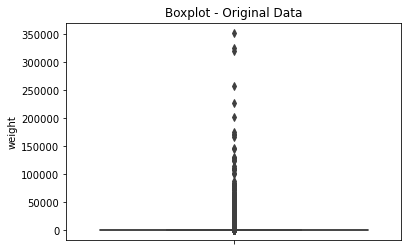

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (89545, 3)


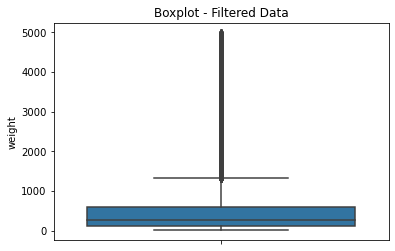

filtered data - stats:
count    89545.000000
mean       509.468792
std        696.317684
min          5.000000
25%        112.000000
50%        260.000000
75%        594.000000
max       4991.000000
Name: weight, dtype: float64


% of removed records: 0.0354


In [3]:
weights_filtered = remove_extreme_weights(weights_df,5,5000)

In [4]:
#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()

In [5]:
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Highly Popular Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df



**Remove Highly Popular Artists**
input data shape: (89545, 3)
unique artists:  17151
line divides top: 80.0 % cumulative sum of users:


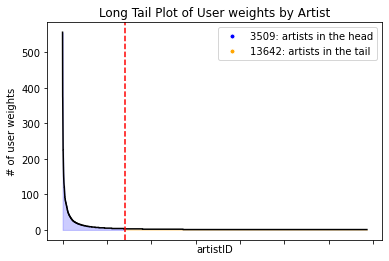

top 10 artists (most users): 
61            Madonna
83          Lady Gaga
148         Radiohead
184              Muse
221       The Beatles
282           Rihanna
283    Britney Spears
294        Katy Perry
327     Avril Lavigne
492          Paramore
Name: name, dtype: object


total removed artists: 172


line divides top: 80.0 % cumulative sum of users:


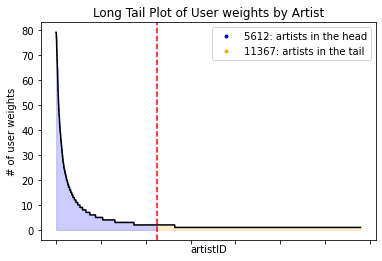

top 10 artists (most users) - filtered dataset: 
185         OneRepublic
259         Céline Dion
290           Sugababes
315      Jonas Brothers
424           Kate Nash
540      The Ting Tings
832              Slayer
845     Alice in Chains
2068             M.I.A.
2328               KISS
Name: name, dtype: object


filtered dataset shape: (61826, 3)
unique artists after removal:  16979
% of removed records: 0.3096


In [6]:
weights_filtered = remove_popular_artists(weights_filtered,artist_df,0.01) 
#changed input data from weights_for_model to weights_filtered here because weights_for_model has not been defined yet.

In [7]:
def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Rare Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df



**Remove Rare Artists**
input data shape: (61826, 3)
unique artists:  16979
line divides top: 80.0 % cumulative sum of users:


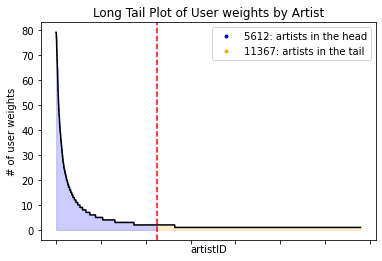

bottom 10 artists: 
9094             Myrmidon Process
9095                The Hannibals
9096             The Pinker Tones
9098     Great Lakes Myth Society
9103                  Saxon Shore
9107                    Lynch Mob
9108                Marconi Union
9116                 Paul Rodgers
9122                        Alpha
17631            Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 15102


line divides top: 80.0 % cumulative sum of users:


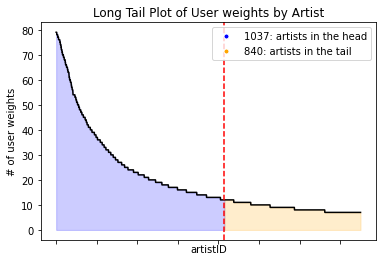

bottom 10 artists - filtered dataset: 
1431          David Bisbal
1494              Nadia Oh
1588     The Cheetah Girls
1651           Blind Melon
3047          Bonnie Tyler
4449         Willie Nelson
4620               Vitalic
4640           Jeremy Camp
4657            Aura Dione
12802             Don Omar
Name: name, dtype: object


filtered dataset shape: (37113, 3)
unique artists after removal:  1877
% of removed records: 0.3997


In [8]:
weights_filtered_rare = remove_rare_artists(weights_filtered,artist_df,7) #Removed the artists with fewer than 7 users.

In [9]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('\n')
    print('**Remove User with lowcount of samples (artists)**')
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [10]:
weights_for_model = remove_users_lowcount(weights_filtered_rare,10)



**Remove User with lowcount of samples (artists)**
df original shape:  (37113, 3)
unique users:  1853
users with less than 10 artists: 118
unique users after removal:  1735
df new shape:  (36470, 3)
% of removed records: 0.0173


In [11]:
#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('\n')
    print('**Scaling**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df




**Scaling**
df original shape:  (36470, 3)


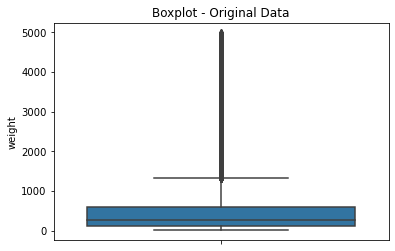

df scaled shape:  (36470, 3)


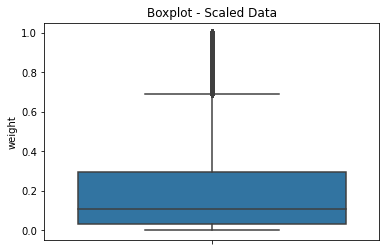

In [12]:
weights_scaled = scale_weight_by_user(weights_for_model)

In [13]:
def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print('\n')
    print('**Train-Test Split**')
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test

In [14]:
train, test = train_test_split(weights_scaled,5,2021)



**Train-Test Split**
input data shape: (36470, 3)
train set shape: (27795, 3)
test set shape: (8675, 3)


OK: all artists from the test set are part on the train set as well


In [15]:
print(weights_scaled.shape,weights_scaled.head())
print(weights_scaled['userID'].max())
print(type(weights_scaled))

(36470, 3)    userID  artistID    weight
0       2        61  1.000000
1       2        63  0.927914
2       2        64  0.893021
3       2        66  0.765721
4       2        68  0.618098
2100
<class 'pandas.core.frame.DataFrame'>


In [16]:
# transform the weights of the matrix into scipy sparse matrix for more efficient calculations
from scipy.sparse import csr_matrix
train_pivot = train.pivot(index = 'userID', columns = 'artistID', values = 'weight').fillna(0)
train_matrix = csr_matrix(train_pivot.values)
test_pivot = test.pivot(index = 'userID', columns = 'artistID', values = 'weight').fillna(0)
test_matrix = csr_matrix(test_pivot.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute') #cosine is used to determine the similarity
model_knn.fit(train_matrix)
print(model_knn)

query_index = np.random.choice(train_pivot.shape[0])
print(query_index)
print(train_pivot.iloc[query_index,:].values.reshape(1,-1))
print(train_pivot.shape[1])

distances, indices = model_knn.kneighbors(train_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
train_pivot.index[query_index]


NearestNeighbors(algorithm='brute', metric='cosine')
1132
[[0. 0. 0. ... 0. 0. 0.]]
1877


1363

In [17]:
#User recommendation
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(train_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, train_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 1363:

1: 29, with distance of 0.3542030597550868:
2: 578, with distance of 0.4197975753585268:
3: 899, with distance of 0.44488529376012864:
4: 1461, with distance of 0.45489955903864576:
5: 1476, with distance of 0.4589265652153134:


In [18]:
#Reduce the dimension of spotify dataset from 11 features to 2, keep the artist and the feature information
from sklearn.decomposition import PCA
artist_sp_df = pd.read_csv(artists_spotify_file)
sp_pca = artist_sp_df.iloc[:,range(2,13)]
pca = PCA(n_components=1)
pca.fit(np.array(sp_pca).T)
new_feature = pd.DataFrame(pca.components_.T, columns = ['feature'])
sp_pca = pd.concat([artist_sp_df.iloc[:,1],new_feature],axis=1)

# Connect the spotify artist name with lm id
feature_df = artist_df.merge(sp_pca,
                        how = 'inner',
                        left_on = artist_df['name'].str.lower(),
                        right_on = sp_pca['artists'].str.lower()).drop(columns = ['key_0','url','pictureURL','name'])
#Merge features with the cleaned user data, merge on artist id

weights_feature = weights_scaled.merge(feature_df,
             how = 'inner',
             left_on = weights_scaled['artistID'],
             right_on = feature_df['id']).drop(columns = ['key_0','id']).drop_duplicates(subset = ['userID','artistID'])

#For each user, find the feature that corresponds to its max weight as the user's favorite feature
#This step can be improved by find the first several features instead of the first one feature.
weights_feature = weights_feature[weights_feature.groupby(['userID'])['weight']
                                  .transform(max) == weights_feature['weight']].drop_duplicates(subset = ['userID'])

weights_feature[weights_feature['userID'] == 1023]

weights_feature

,userID,artistID,weight,artists,feature
0,2,61,1.000000,Talk Talk,0.008036
21,1585,61,1.000000,Talk Talk,0.008036
31,210,63,0.620359,Enigma,0.006585
37,463,63,1.000000,Enigma,0.006585
46,831,63,1.000000,Enigma,0.006585
...,...,...,...,...,...
29061,1364,2873,0.475504,Joe Bonamassa,0.010368
29069,1347,11885,0.521739,Johnny Winter,0.006049
29080,1627,2871,1.000000,Rory Gallagher,0.006916
29084,1148,6150,1.000000,Tangerine Dream,0.013529


In [19]:
def usertofeature(userlist):
    featurelist = []
    for i in userlist:
        feature = weights_feature.loc[weights_feature['userID'] == i, 'feature'].tolist()
        featurelist+=feature
    return featurelist
usertofeature([324, 1839, 1868, 1858, 715, 1008])

[0.006492758388774683,
 0.006492758388774683,
 0.007168669901198889,
 0.006560985342133663,
 0.0055294568627040006,
 0.005463232233567679]

In [20]:
# Find the favorite feature list of each neighbor user, average them to get the synthetic artist
neighbor = 6
SA = [] #The list of synthetic artist feature that cooresponds to the user list
AA = [] #The actual artist feature that corresponds to the user list
for query_index in range(0,train_pivot.shape[0]):
    if train_pivot.index[query_index] in weights_feature['userID'].to_list():
        distances, indices = model_knn.kneighbors(train_pivot.iloc[query_index,:].values.reshape(1, -1), 
                                              n_neighbors = neighbor)
        userlist = train_pivot.index[indices.flatten()].tolist()
        featurelist = usertofeature(userlist)
        synartist = sum(featurelist)/len(featurelist)
        SA.append(synartist)
        AA.append((weights_feature.loc[weights_feature['userID'] == train_pivot.index[query_index], 'feature']).tolist())
    else:
        print("No enough data to make recommendation")

AA = np.array(AA).flatten()
SA = np.array(SA)

The percentage that synthetic artist different than the actual artist features is:  [ 0.25135888 -0.29546373 -0.18562282 ...  0.11687463 -0.05535125
  0.17026336]


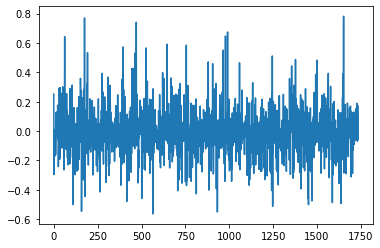

In [34]:
#Compare the feature of the synthetic artist feature
compare = AA/SA-1
print("The percentage that synthetic artist different than the actual artist features is: ", compare)
plt.plot(compare)

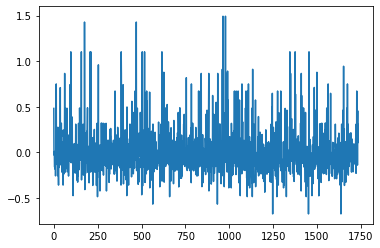

In [35]:
#If we only use AA mean to assume all the features, the range is bigger.
AAmean = np.average(AA)
original = AA/AAmean-1
plt.plot(original)